# Longitudinal QuasiCopula GWAS with Mixed Marginals

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays

BLAS.set_num_threads(1)
Threads.nthreads()

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end


┌ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1423


_make_snparray (generic function with 1 method)

## Simulate data

In [26]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 2, # number of variance components
    q = 1000,
    k = 10,
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
    βtrue = y_distribution == Bernoulli ? rand(Uniform(-2, 2), p) : rand(Uniform(-0.2, 0.2), p)
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.5, m)
    V1 = ones(d, d)
    V2 = Matrix(I, d, d)
    Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2

    # simulate design matrices
    Random.seed!(seed)
    X_full = [hcat(ones(d), randn(d, p - 1)) for i in 1:n]

    # simulate random SnpArray with 100 SNPs and randomly choose 10 SNPs to be causal
    Random.seed!(2022)
    G = simulate_random_snparray(undef, n, q)
    Gfloat = convert(Matrix{T}, G, center=true, scale=true)
    γtrue = zeros(q)
    γtrue[1:k] .= y_distribution == Bernoulli ? rand([-1, 1], k) : rand([-0.2, 0.2], k)
    shuffle!(γtrue)
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 100.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = y_distribution == Normal ? 
                Vector{ContinuousUnivariateDistribution}(undef, d) : 
                Vector{DiscreteUnivariateDistribution}(undef, d)
            for i in 1:d
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, d)
            res = Vector{T}(undef, d)
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, G, βtrue, θtrue, γtrue
end

gcm, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 1000, # sample size
    d = 5, # number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 1, # number of variance components
    q = 1000,
    k = 10,
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
)

@show gcm;

gcm = Quasi-Copula Variance Component Model
  * base distribution: Bernoulli
  * link function: LogitLink
  * number of clusters: 1000
  * cluster size min, max: 5, 5
  * number of variance components: 1
  * number of fixed effects: 3



## Fit Null model

TODO: 
+ Why are p-values deflated? 
+ How to compute $\nabla$res$\beta$ for Gaussian?

In [27]:
@time optm = QuasiCopula.fit!(gcm,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 1000,
        accept_after_max_steps = 4,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="second-order"
    )
);

initializing β using Newton's Algorithm under Independence Assumption
gcm.β = [-0.4802653294656028, 0.555057799753852, 0.033779935702975925]
initializing variance components using MM-Algorithm
gcm.θ = [0.44793095107746295]
This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        1
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:   

In [28]:
@show βtrue
@show gcm.β
@show gcm.∇β

@show θtrue
@show gcm.θ
@show gcm.∇θ;

βtrue = [-1.572454184822588, 1.622105756389522, 0.08250501994707893]
gcm.β = [-0.3985475795642787, 0.6457898582603484, 0.034335309326271525]
gcm.∇β = [3.5620513205714133e-9, 3.907250023527098e-9, -9.61801305265908e-10]
θtrue = [0.5]
gcm.θ = [0.4814369697485429]
gcm.∇θ = [-4.941276054992727e-9]


## Score test

In [29]:
loglikelihood!(gcm, true, true)
@time pvals = QuasiCopula.GWASCopulaVCModel(gcm, G)

  1.448737 seconds (14.29 M allocations: 1.370 GiB, 7.14% gc time, 12.33% compilation time)


1000-element Vector{Float64}:
 0.8300686989627077
 0.6864214507456917
 0.42547043042914046
 0.25716397279195985
 0.6986399435078081
 0.974602270927425
 0.6960167245102458
 0.7850414090886068
 0.7890294894392674
 0.7923431994682063
 0.6612225678164163
 0.801407722958675
 0.9622074767370108
 ⋮
 0.6575902062337411
 0.4661905458552207
 0.9510066169750974
 0.9064037937310594
 0.8576247389490822
 0.989542333752513
 0.9092061988266606
 0.9682091189449421
 0.6989153290017734
 0.6286328827048812
 0.9367931644852712
 0.46489339146699055

In [30]:
correct_snps = findall(!iszero, γtrue)
signif_snps = findall(x -> x < 0.05/length(pvals), pvals)
power = length(correct_snps ∩ signif_snps) / length(correct_snps)

@show length(signif_snps)
@show power

length(signif_snps) = 1
power = 0.1


0.1

In [31]:
pvals[correct_snps] |> sort

10-element Vector{Float64}:
 1.8063405971753447e-5
 0.0005990837287096265
 0.0016061646984477861
 0.0022450937403552746
 0.0035798573799396415
 0.00672280536189122
 0.010222855526197417
 0.013382817178337697
 0.037132907895428266
 0.03977960479644273

In [32]:
sort(pvals)

1000-element Vector{Float64}:
 1.8063405971753447e-5
 0.0005990837287096265
 0.0016061646984477861
 0.0022450937403552746
 0.0035798573799396415
 0.00672280536189122
 0.010222855526197417
 0.013382817178337697
 0.037132907895428266
 0.03977960479644273
 0.1302244215093526
 0.1328330865959169
 0.14881654836733008
 ⋮
 0.9921029342825521
 0.9924523679509282
 0.9932377279061649
 0.993927921775773
 0.9945997917769434
 0.9946338825514949
 0.9954906927963434
 0.9959136374255743
 0.9961143112251536
 0.9970290722703493
 0.9975572065740008
 0.9982365770592403

## QQ Plots

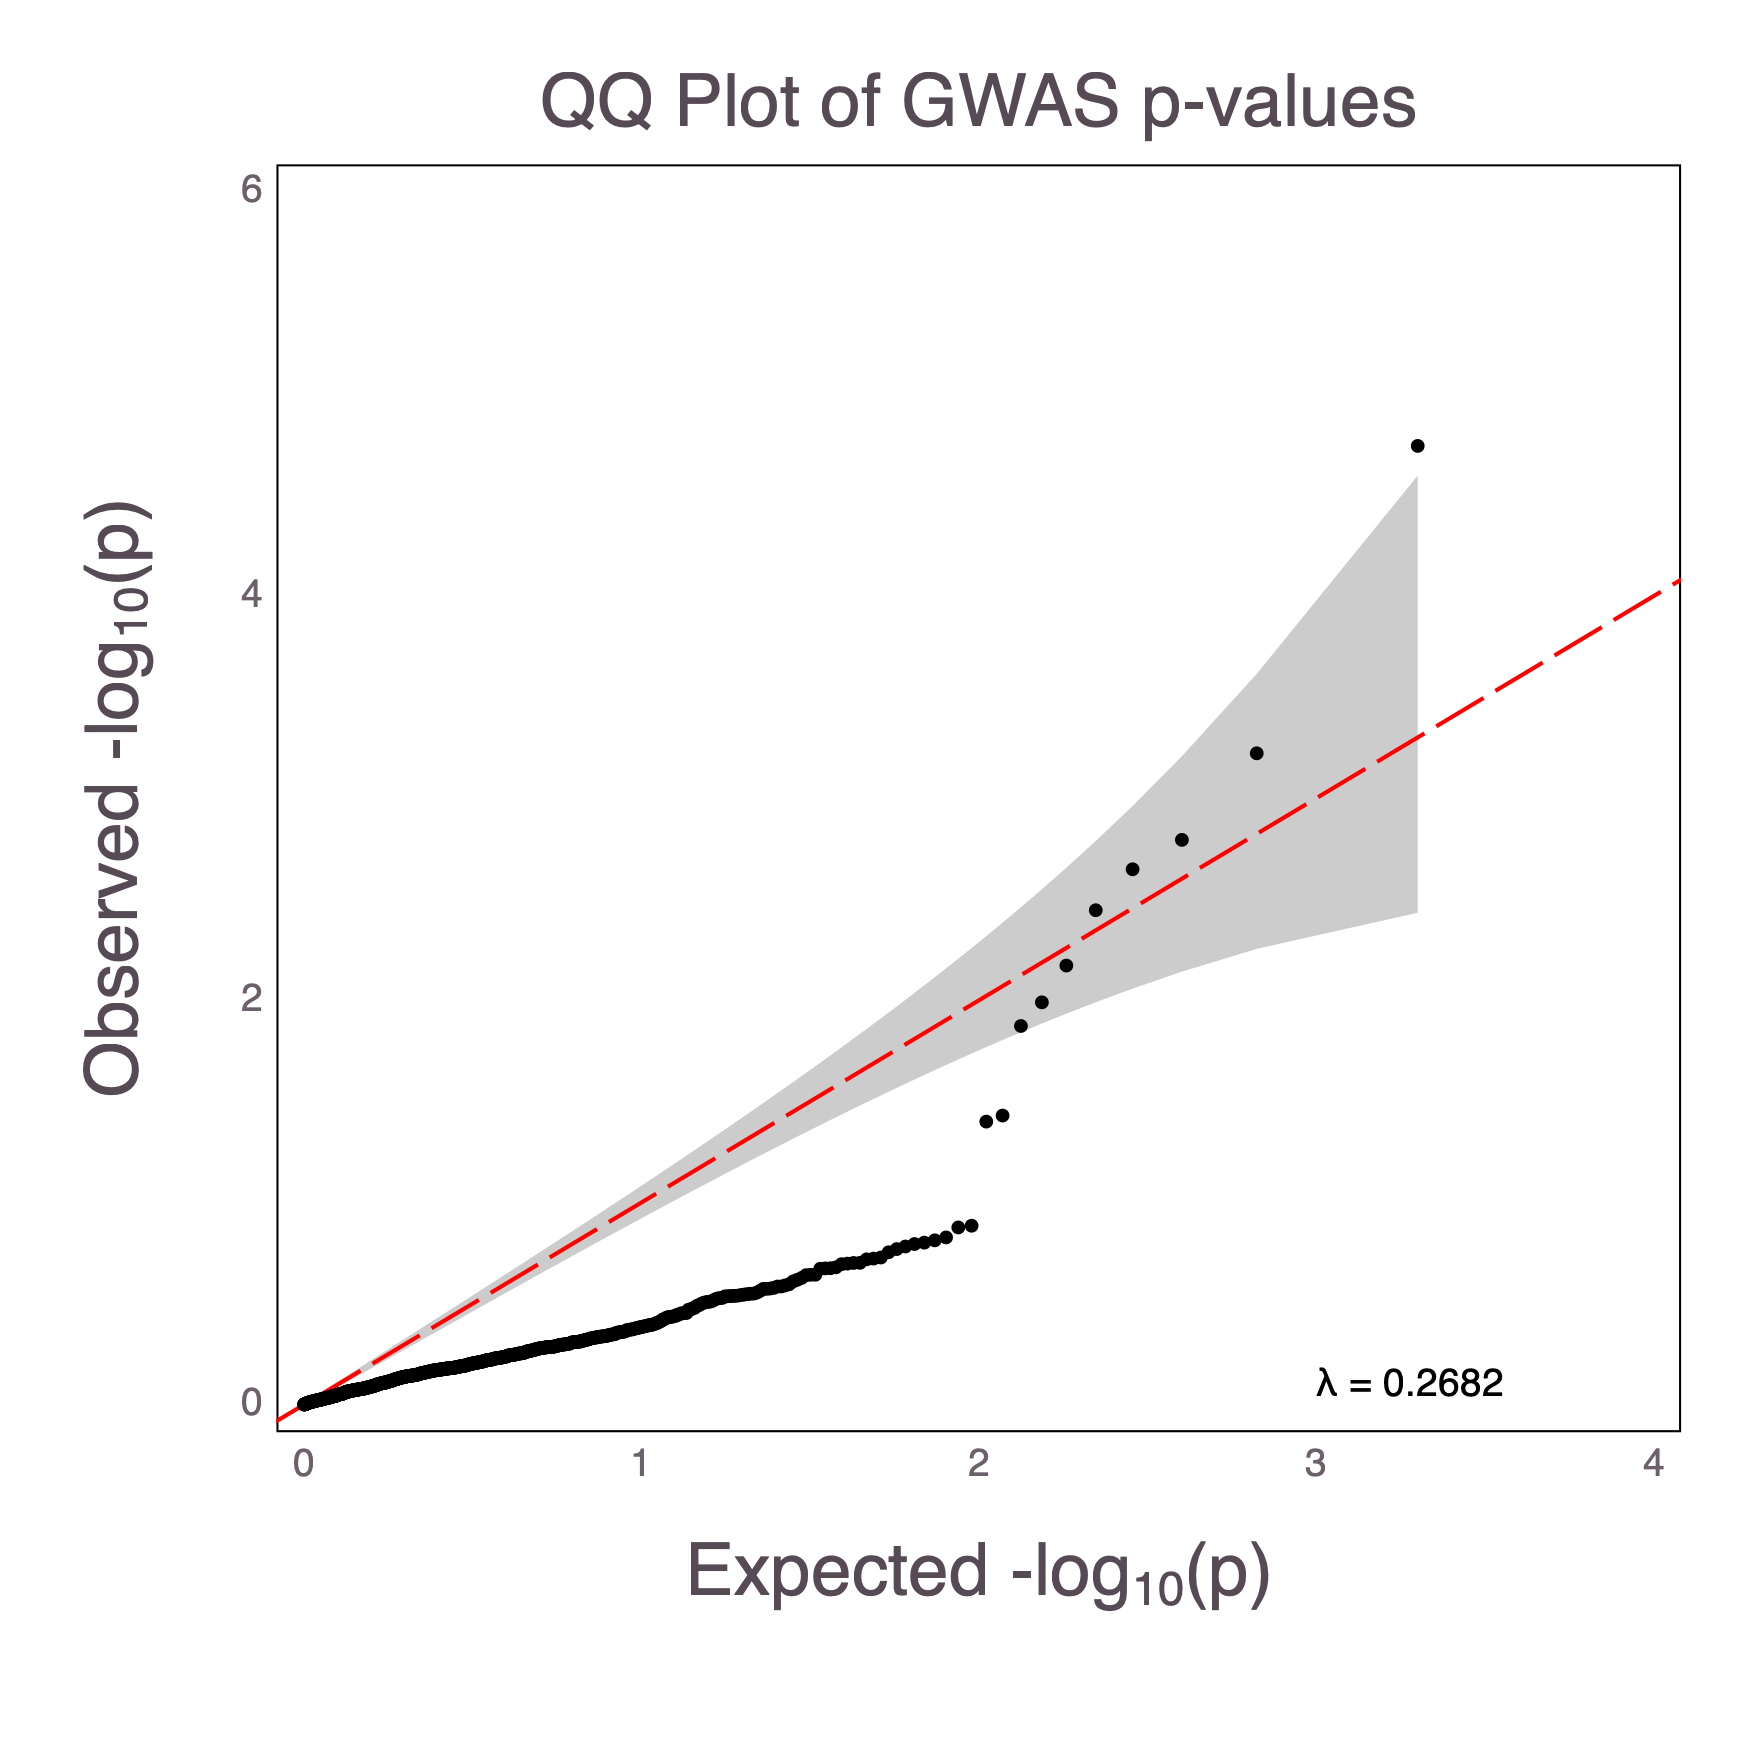

In [33]:
using MendelPlots
qq(pvals)
display("image/png", read("qqplot.png"))